In [1]:
import os
import numpy as np
import torch
from torchsummary import summary
import copy
import matplotlib.pyplot as plt

import scipy.io.wavfile
import cupy as cp
import cusignal

from IPython.display import Audio

In [2]:
class data_from_dir(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, file_dir, resample=False):
        'Initialization'
        self.resample = resample
        self.file_dir = file_dir
        self.file_filenames = [ x for x in os.listdir(file_dir) ]
        
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.file_filenames)

    def __getitem__(self, index, resample=False):
        'Load one sample of data'
        # Select sample
        sr, wave = scipy.io.wavfile.read(os.path.join(self.file_dir, self.file_filenames[index]))
        if self.resample:
            # Let's resample and scale:
            target_length = 5 # seconds
            target_sr = 48000 # sampling rate, samples per second
            wave_gpu = cp.asarray(wave)
            resampled_wave_gpu = cusignal.resample(wave_gpu, target_sr*target_length)
            resampled_wave = cp.asnumpy(resampled_wave_gpu).astype(int)
            scaled_wave = np.int16(resampled_wave/np.max(np.abs(resampled_wave)) * 32767)
            return scaled_wave.reshape(1, -1) # each element in array is one-dimensional, so need to reshape as 1-dimensional array
        else:
            return wave.reshape(1, -1)
            

In [3]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [4]:
%%time
# dataset = data_from_dir("../data/dataset/resampled", resample=False) # load already prepared and resampled files
# dataset = data_from_dir("../data/dataset/25G_train", resample=False) # load already prepared and resampled files
dataset = data_from_dir("../../data/dataset/small", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(dataset))

# # check all files to be consistent before pass to neural network
# for index, wave in enumerate(dataset):
#     if len(wave[0]) != 240000:
#         print("Size error:     ", dataset.file_filenames[index])
#         print("Current length: ", len(dataset[index]))
#         break
# if index+1 == len(dataset):
#     print("All files consistent and have same length 240k amplitudes each")
# print()
# print()

# wave

Dataset size:  2000
CPU times: user 2.22 ms, sys: 313 µs, total: 2.53 ms
Wall time: 1.76 ms


In [5]:
%%time
# now split whole dataset to train and test subsets
# get 50% for tests

train_size = int(0.5 * len(dataset))
# train_size = int(0.961 * len(dataset))
# train_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print("Train dataset size: ", len(train_dataset))
print("Test dataset size:  ", len(test_dataset))
print()

Train dataset size:  1000
Test dataset size:   1000

CPU times: user 817 µs, sys: 115 µs, total: 932 µs
Wall time: 662 µs


In [6]:
%%time
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True) #, num_workers=4) # num_workers have an issue, not working
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True) #, num_workers=4)

CPU times: user 111 µs, sys: 0 ns, total: 111 µs
Wall time: 115 µs


In [7]:
### library for plot online update
from livelossplot import PlotLosses

dataloaders = {
    "train": train_loader,
    "test": test_loader
}

In [8]:
# describe model architecture

class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        kernel_size_1 = int(64) # 64
        kernel_size_2 = int(25) # 25
        kernel_size_3 = int(25) # 25
        padding_1 = int((kernel_size_1 - 1)/2) # 
        padding_2 = int((kernel_size_2 - 1)/2) #
        padding_3 = int((kernel_size_3 - 1)/2) #
        # ReLU = 0.0056
        # ReLU6 = 0.0055
        # LeakyReLU(0.1) = 0.0053
        # Hardtanh = 0.0072
        # PReLU = 0.0055
        # RReLU = 0.0055
        # SELU = 0.0067
        
        self.activation = torch.nn.LeakyReLU(0.1)

        self.enc1co = torch.nn.Conv1d(1, 32, kernel_size=kernel_size_1, stride=16, padding=padding_1)
        self.enc1bn = torch.nn.BatchNorm1d(32)
        self.enc1ac = self.activation
        
        self.enc2co = torch.nn.Conv1d(32, 64, kernel_size=kernel_size_2, stride=5, padding=padding_2)
        self.enc2bn = torch.nn.BatchNorm1d(64)
        self.enc2ac = self.activation
        self.enc2mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)
        
        self.enc3co = torch.nn.Conv1d(64, 128, kernel_size=kernel_size_3, stride=5, padding=padding_3)
        self.enc3bn = torch.nn.BatchNorm1d(128)
        self.enc3ac = self.activation
        self.enc3mp = torch.nn.MaxPool1d(kernel_size=5, stride=5, return_indices=True)
        
        self.dec3mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
        self.dec3uco = torch.nn.ConvTranspose1d(128, 64, kernel_size=kernel_size_3, stride=5, padding=padding_3-2)
        self.dec3bn = torch.nn.BatchNorm1d(64)
        self.dec3ac = self.activation

        self.dec2mup = torch.nn.MaxUnpool1d(kernel_size=5, stride=5)
        self.dec2uco = torch.nn.ConvTranspose1d(64, 32, kernel_size=kernel_size_2, stride=5, padding=padding_2-2)
        self.dec2bn = torch.nn.BatchNorm1d(32)
        self.dec2ac = self.activation
        
        self.dec1uco = torch.nn.ConvTranspose1d(32, 1, kernel_size=kernel_size_1, stride=16, padding=padding_1-7)
        self.dec1bn = torch.nn.BatchNorm1d(1)
        self.dec1ac = torch.nn.Sigmoid() # data range will be transformed to [0..1]
        
        # now initialize weights
        torch.nn.init.kaiming_uniform_(self.enc1co.weight)
        torch.nn.init.kaiming_uniform_(self.enc2co.weight)
        torch.nn.init.kaiming_uniform_(self.enc3co.weight)
        torch.nn.init.kaiming_uniform_(self.dec3uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec2uco.weight)
        torch.nn.init.kaiming_uniform_(self.dec1uco.weight)

    def forward(self, x):
        self.enc1bn.eval() # freeze running_mean and running_std
        x = self.enc1ac(self.enc1bn(self.enc1co(x)))
        self.enc2bn.eval() # freeze running_mean and running_std
        x = self.enc2ac(self.enc2bn(self.enc2co(x)))
        x,self.idx2 = self.enc2mp(x)
        x = self.enc3ac(self.enc3bn(self.enc3co(x)))
        x,self.idx3 = self.enc3mp(x)
        
        x = self.dec3mup(x, self.idx3)
        x = self.dec3ac(self.dec3bn(self.dec3uco(x)))
        x = self.dec2mup(x, self.idx2)
        self.dec2bn.eval() # freeze running_mean and running_std
        x = self.dec2ac(self.dec2bn(self.dec2uco(x)))
        self.dec1bn.eval() # freeze running_mean and running_std
        x = self.dec1ac(self.dec1bn(self.dec1uco(x)))
        return x
    
    def trained_forward(self, x):
        x = self.enc1ac(self.enc1bn(self.enc1co(x)))
        x = self.enc2ac(self.enc2bn(self.enc2co(x)))
        x,self.idx2 = self.enc2mp(x)
        
        x = self.dec2mup(x, self.idx2)
        x = self.dec2ac(self.dec2bn(self.dec2uco(x)))
        x = self.dec1ac(self.dec1bn(self.dec1uco(x)))
        return x

In [9]:
model_path = "../../models/ConvAutoEncoder.l2.000-5.000-5.model.pt"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
loaded_model = torch.load(model_path, map_location=device)

In [10]:
model = ConvAutoencoder()
model.cuda() # need to be set to cuda to get summary working
summary(model, (1, 240000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 32, 15000]           2,080
       BatchNorm1d-2            [-1, 32, 15000]              64
         LeakyReLU-3            [-1, 32, 15000]               0
            Conv1d-4             [-1, 64, 3000]          51,264
       BatchNorm1d-5             [-1, 64, 3000]             128
         LeakyReLU-6             [-1, 64, 3000]               0
         MaxPool1d-7  [[-1, 64, 600], [-1, 64, 600]]               0
            Conv1d-8             [-1, 128, 120]         204,928
       BatchNorm1d-9             [-1, 128, 120]             256
        LeakyReLU-10             [-1, 128, 120]               0
        MaxPool1d-11  [[-1, 128, 24], [-1, 128, 24]]               0
      MaxUnpool1d-12             [-1, 128, 120]               0
  ConvTranspose1d-13              [-1, 64, 600]         204,864
      BatchNorm1d-14         

In [11]:
# copy loaded model to model
model.enc1co = copy.deepcopy(loaded_model.enc1co)
model.enc1bn = copy.deepcopy(loaded_model.enc1bn)
model.enc2co = copy.deepcopy(loaded_model.enc2co)
model.enc2bn = copy.deepcopy(loaded_model.enc2bn)

model.dec2uco = copy.deepcopy(loaded_model.dec2uco)
model.dec2bn = copy.deepcopy(loaded_model.dec2bn)
model.dec1uco = copy.deepcopy(loaded_model.dec1uco)
model.dec1bn = copy.deepcopy(loaded_model.dec1bn)

In [12]:
# Need to set .eval() on every freezed BN in class description!!!
# now freeze previously trained layers:
model.enc1co.weight.requires_grad=False
model.enc1co.bias.requires_grad=False
model.enc1bn.weight.requires_grad=False
model.enc1bn.bias.requires_grad=False
model.enc2co.weight.requires_grad=False
model.enc2co.bias.requires_grad=False
model.enc2bn.weight.requires_grad=False
model.enc2bn.bias.requires_grad=False

model.dec2uco.weight.requires_grad=False
model.dec2uco.bias.requires_grad=False
model.dec2bn.weight.requires_grad=False
model.dec2bn.bias.requires_grad=False
model.dec1uco.weight.requires_grad=False
model.dec1uco.bias.requires_grad=False
model.dec1bn.weight.requires_grad=False
model.dec1bn.bias.requires_grad=False

In [13]:
# train on cuda if available
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# train with (test on each epoch)
def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    amplitude_range = 32767*2 + 1.0 # = 65535
    
    for epoch_id, epoch in enumerate(range(num_epochs)):
        logs = {}
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            for idx, inputs in enumerate(dataloaders[phase]):
                inputs = 0.5 + (inputs/amplitude_range) # [0..1]
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = (criterion(outputs, inputs))

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                running_loss += loss.detach() * inputs.size(0)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)           
            prefix = ''
            if phase == 'test':
                prefix = 'val_'
            logs[prefix + 'log loss'] = epoch_loss.item()
        liveloss.update(logs)
        liveloss.send()
        print(f"\n[{epoch_id+1}/{num_epochs}]    {logs}")
    print("\nTrained.")

In [14]:
torch.cuda.empty_cache()
criterion = torch.nn.MSELoss()
# criterion = FocalLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.00005) # [0.001 .. 0.0005 ... 0.0001] 0.001 per 10 epochs & 0.00001 per 1000 epochs

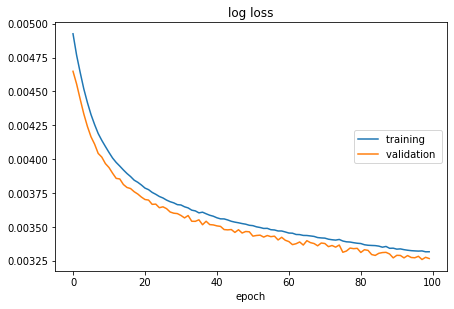

log loss
	training         	 (min:    0.003, max:    0.005, cur:    0.003)
	validation       	 (min:    0.003, max:    0.005, cur:    0.003)

[100/100]    {'log loss': 0.0033159989397972822, 'val_log loss': 0.003266035346314311}

Trained.
CPU times: user 11min 1s, sys: 4min 6s, total: 15min 7s
Wall time: 3min 50s


In [15]:
%%time
train_model(model, criterion, optimizer, num_epochs=100) # start @ 10:35:30

In [16]:
%%time
validation_dataset = data_from_dir("../../data/dataset/test", resample=False) # load already prepared and resampled files
print("Dataset size: ", len(validation_dataset))

# check one file in dataset to be sure everything is good:
file_number=10
wave = validation_dataset[file_number][0]
sr = 48000

print('Type:              ', type(wave))
print('Data:              ', wave)
print('Sampling rate:     ', sr)
print('Samples:           ', len(wave))
print('Audio length:      ', round(wave.size/sr, 4), 'seconds')
print('Lowest amplitude:  ', min(wave))
print('Highest amplitude: ', max(wave))
print()
print("Scaled from dataset:")
Audio(wave, rate=sr)

Dataset size:  524
Type:               <class 'numpy.ndarray'>
Data:               [-6470 -6514 -5670 ...  -516   138 -2428]
Sampling rate:      48000
Samples:            240000
Audio length:       5.0 seconds
Lowest amplitude:   -32767
Highest amplitude:  28877

Scaled from dataset:
CPU times: user 103 ms, sys: 1.14 ms, total: 104 ms
Wall time: 102 ms


In [17]:
wave = validation_dataset[file_number][0]
amplitude_range = 32767*2+1.0 # = 65535
inputs = torch.Tensor([[0.5 + wave/amplitude_range]]) # [0..1]
inputs = inputs.to(device)
new_outputs = model.forward(inputs)
prev_outputs = model.trained_forward(inputs)
# loss = (criterion(outputs, inputs))
# print(f"loss: {loss.item()}")
prev_result = np.int16(((prev_outputs - 0.5)*(amplitude_range-1)).detach().cpu())
new_result = np.int16(((new_outputs - 0.5)*(amplitude_range-1)).detach().cpu())
Audio(new_result[0][0], rate=sr)

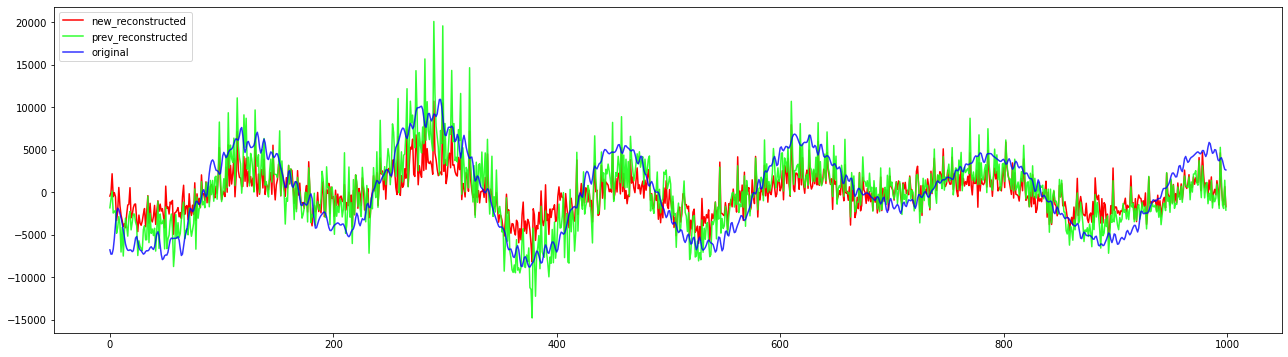

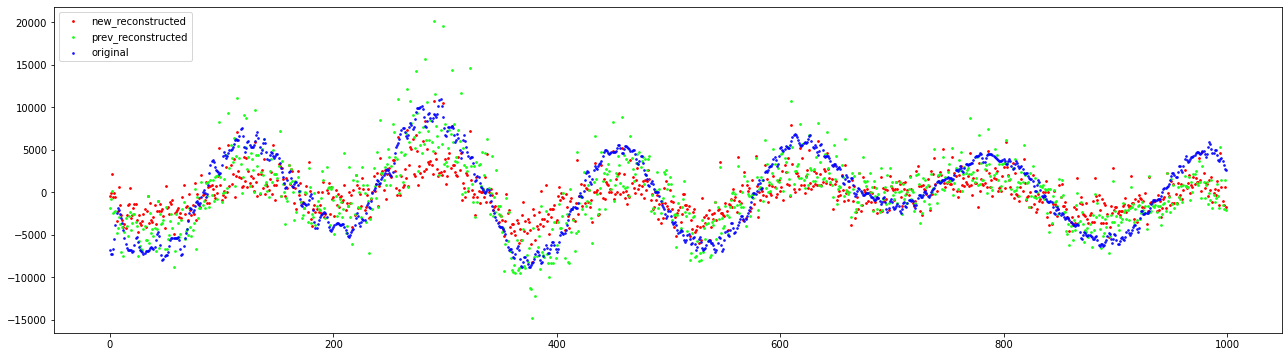

In [18]:
amp_start = 1000
amp_end =   2000
plt.figure(figsize=(22,6))
plt.plot(new_result[0][0][amp_start:amp_end], linestyle="-", color=[1.0, 0.0, 0.0, 1.0], label="new_reconstructed") # RED plotting by columns
plt.plot(prev_result[0][0][amp_start:amp_end], linestyle="-", color=[0.1, 1.0, 0.1, 0.9], label="prev_reconstructed") # GREEN plotting by columns
plt.plot(wave[amp_start:amp_end], linestyle="-", color=[0.0, 0.0, 1.0, 0.8], label="original") # BLUE plotting by columns
plt.legend(loc="upper left")
plt.show()

plt.figure(figsize=(22,6))
x = np.arange(0, amp_end-amp_start)
plt.scatter(x, new_result[0][0][amp_start:amp_end], s=3, color=[1.0, 0.0, 0.0, 1.0], label="new_reconstructed") # RED plotting by columns
plt.scatter(x, prev_result[0][0][amp_start:amp_end], s=3, color=[0.1, 1.0, 0.1, 1.0], label="prev_reconstructed") # GREEN plotting by columns
plt.scatter(x, wave[amp_start:amp_end], s=3, color=[0.0, 0.0, 1.0, 0.8], label="original") # BLUE plotting by columns
plt.legend(loc="upper left")
plt.show()

In [19]:
model_path = "../../models/ConvAutoEncoder.l3.000-5.000-5.model.pt"
torch.save(model, model_path)
os.chown(model_path, 1000, 1000)

/opt/miniconda/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type ConvAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
